# DLP Pipeline Inference Workflow

## 1. Introduction
Data Loss Prevention (DLP) is a set of tools, technologies, and processes designed to detect, monitor, and prevent the unauthorized transmission, or exposure of sensitive information. Modern DLP solutions include a combination of policy enforcement, content inspection, contextual analysis, and protective measures such as encryption, access restrictions, alerting, and remediation actions. This workflow shows an inference DLP pipeline solution that combines regex pattern matching with small language model (SLM) powered semantic analysis for personal identifiable information (PII).
Namely, the workflow focuses on detecting selected personal sensitive information (PIIs), such as SSNs, passwords, emails, etc., in raw text format.

#### The Role of Modern DLP Systems

**Effective DLP systems are essential in today’s enterprise and cloud environments to:**

- **Prevent Sensitive Data Leakage**: Identify and mitigate exposure of Personally Identifiable Information (PII), Protected Health Information (PHI), credentials, and intellectual property.
- **Ensure Regulatory Compliance**: Meet data protection mandates such as GDPR, HIPAA, PCI-DSS, and ISO 27001.
- **Detect Insider Threats**: Monitor and flag suspicious access to sensitive data by internal actors.
- **Secure Cloud and SaaS Workloads**: Protect data in motion and at rest across hybrid and multi-cloud architectures.

#### Traditional DLP Limitations
Traditional DLP systems for PII detection rely mostly on manually curated regular expressions and rule-based pattern matching. While these systems are fast and interpretable, they have several limitations, including:

- **High False Positives**: Rule-based systems generate excessive alerts by matching anything that resembles  the target PII. For example, a benign nine-digit number could easily be misidentified as SSN. 
- **Limited Context**: Cannot understand semantic meaning. 
- **Maintenance Overhead**: Patterns requires constant update to match evolving inputs.


#### Hybrid Solution

To overcome these limitations, this workflow implements a hybrid DLP pipeline that combines:
- Regex-based pre-filtering for fast and scalable detection with high recall.
- Contextual entity validation using a lightweight SLM (e.g., DeBERTa-based GLiNER), reducing false positives by leveraging semantic information from the surrounding text window.

This architecture offers a pragmatic trade-off between speed, accuracy, and contextual sensitivity in a pipeline that includes:
- **Regex Pattern Matching**: Fast, rule-based detection using curated regular expressions.
- **Context Aware Small Language Model**: A fine-tuned, GLiNER-based small language model for PII detection.


*This workflow shows walking through of the DLP pipeline for PII detection, for more optimized, please refer to the Morpheus implemention of the pipeline at [Morpheus DLP pipeline implementation](https://github.com/nv-morpheus/Morpheus/tree/branch-25.06/examples/data_loss_prevention)*



In [32]:
#!pip install -q -U nervaluate  gliner tqdm datasets

In [53]:
%load_ext autoreload
%autoreload 2

import json
import os

import pandas as pd
from dlp_pipeline import DLPPipeline

from util import (
    evaluate_results, run_benchmark_pipeline
)
from plot_util import (
    make_metrics_per_entity,
    visualize_benchmark_results,
    plot_detail_metrics,
    visualize_latency,
    visualize_risk_assessment
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Dataset and Processing

### 2.1. Synthetic Data for Safe Demonstration

We use the [gretelai/gretel-pii-masking-en-v1](https://huggingface.co/datasets/gretelai/gretel-pii-masking-en-v1) dataset to safely demonstrate DLP capabilities without exposing real sensitive information. The dataset is a synthetically generated collection of documents enriched with Personally Identifiable Information (PII) and Protected Health Information (PHI) entities spanning multiple domains.

 


In [34]:
from dataset_creation import load_and_process_datasets

print(" Loading Gretel synthetic dataset...")
gretel_dataset = load_and_process_datasets(['gretel'], num_samples=2000)

print(f" Dataset loaded: {len(gretel_dataset)} samples")
print(f"  Average text length: {gretel_dataset['source_text'].str.len().mean():.0f} characters")

# Display sample
sample_text = gretel_dataset['source_text'].iloc[0]
print(f"\n Sample text preview:\n{sample_text[:300]}...")


 Loading Gretel synthetic dataset...
Loading datasets: ['gretel']
 Dataset loaded: 2000 samples
  Average text length: 218 characters

 Sample text preview:
Mclaughlin-Peters, hereafter referred to as the Producer, agrees to license the exclusive rights to Danielle Lyons' music catalog, as defined in Exhibit A, to I1976524, hereafter referred to as the Licensee, for use in the Licensee's audiovisual production....


In [35]:
gretel_dataset['source_text'].iloc[0]

"Mclaughlin-Peters, hereafter referred to as the Producer, agrees to license the exclusive rights to Danielle Lyons' music catalog, as defined in Exhibit A, to I1976524, hereafter referred to as the Licensee, for use in the Licensee's audiovisual production."

## 2. Load and Configure Regex Patterns

Next, we'll load the regex patterns from the benchmark patterns file.

In [36]:
# Load regex patterns
regex_file = "data/regex_patterns.json"

if not os.path.exists(regex_file):
    # Create a basic set of patterns as fallback
    patterns = {
        "credit_card_number": [
            r"\b(?:4[0-9]{12}(?:[0-9]{3})?|5[1-5][0-9]{14}|3[47][0-9]{13}|3(?:0[0-5]|[68][0-9])[0-9]{11}|6(?:011|5[0-9]{2})[0-9]{12}|(?:2131|1800|35\d{3})\d{11}|(?:\d{4}[-\s]?){3}\d{4}|\d{16})\b"
        ],
        "ssn": [
            r"\b\d{3}[-\s]?\d{2}[-\s]?\d{4}\b"
        ],
        "email": [
            r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b"
        ],
        "phone_number": [
            r"\b(?:\+?1[-\.\s]?)?(?:\(\d{3}\)|\d{3})[-\.\s]?\d{3}[-\.\s]?\d{4}\b|\b\d{10}\b"
        ],
        "ipv4": [
            r"\b(?:\d{1,3}\.){3}\d{1,3}\b"
        ],
        "date": [
            r"\b\d{1,2}[\/\-\.]\d{1,2}[\/\-\.]\d{2,4}\b"
        ]
    }
else:
    with open(regex_file, 'r') as f:
        patterns = json.load(f)

print(f"Loaded {len(patterns)} regex pattern groups")
print(f"Configured {len(patterns)} pattern categories:")
for pattern_type in patterns.keys():
    print(f"  • {pattern_type}")

Loaded 41 regex pattern groups
Configured 41 pattern categories:
  • medical_record_number
  • date_of_birth
  • ssn
  • date
  • first_name
  • email
  • last_name
  • customer_id
  • employee_id
  • name
  • phone_number
  • ipv4
  • credit_card_number
  • license_plate
  • address
  • user_name
  • device_identifier
  • bank_routing_number
  • date_time
  • company_name
  • unique_identifier
  • biometric_identifier
  • account_number
  • city
  • certificate_license_number
  • time
  • postcode
  • vehicle_identifier
  • coordinate
  • country
  • api_key
  • ipv6
  • password
  • health_plan_beneficiary_number
  • national_id
  • tax_id
  • url
  • state
  • swift_bic
  • cvv
  • pin


In [37]:
print(f"Total number of regex patterns: {sum(len(values) for key, values in patterns.items())}")

Total number of regex patterns: 223


## 3. DLP Pipeline

The DLP workflow consists of several components. 

1. **Input Text/Documents**: Raw input data, such as text files or documents, are fed into the system.
   
2. **Preprocessing & Chunking**: If necessary, the input text is cleaned, normalized, and divided into manageable chunks to enable efficient processing.

3. **Regex Scanner (Fast Pass)**: A high-speed, rule-based regex engine performs an initial scan to quickly identify potential sensitive data patterns.
This step filters obvious matches and includes a configurable context window of tokens $∣w∣$ before and after each detected match. A curated set of regex rules is used to detect predefined entity categories, as defined in the regex configuration file.
4. **SLM (Small Laguage Model)**: The remaining chunks undergo advanced analysis using a semantic AI model using GLiNER model, which interprets data contextually to detect complex sensitive information that regex alone might miss. Specifically, we use the fine-tuned GLiNER  `gretelai/gretel-gliner-bi-small-v1.0` [2] model as a base SLM model.The Gretel GLiNER model is a customized variant of the GLiNER base model, `knowledgator/gliner-bi-small-v1.0`, 
fine-tuned specifically for identifying Personally Identifiable Information (PII) and Protected Health Information (PHI). 

5. **Risk Analysis & Reporting**: The detected entities are assessed for risk, categorized by severity, and formatted into actionable reports suitable for compliance review or policy enforcement.


![dlp_pipeline_diagram.png](data/dlp_pipeline_diagram.png)

### 3.1 Pipeline Document Processing   




In [38]:
test_documents = [
    {
        "title": "Patient Information",
        "content": """
PATIENT INFORMATION
Medical Record #: MRN-12345678
Name: John Smith
DOB: 01/15/1985
SSN: 123-45-6789
Address: 5678 Pine Avenue, Apt 302, Chicago, IL 60601
Phone: 773-555-1234
Email: jsmith@email.net
Insurance ID: INS-987654321

VISIT SUMMARY
Date: 03/22/2023
Time: 14:30
Provider: Dr. Sarah Johnson, MD (NPI: 1234567890)
Diagnosis: Hypertension (ICD-10: I10)
Medications: Lisinopril 10mg daily
Follow-up: 3 months
"""
    },
    {
        "title": "Config File with API Keys",
        "content": """
# Production API Configuration
api_key = "ak_live_HJd8e7h23hFxMznWcQE5TWqL"
api_secret = "sk_test_abcdefghijklmnopqrstuvwxyz12345"
debug = false

# Database Connection
DB_HOST = "db.example.com"
DB_USER = "admin"
DB_PASSWORD = "SecurePassword123!"
"""
    },
    {
        "title": "Order Receipt",
        "content": """
PURCHASE RECEIPT

Customer: Jane Doe
Email: jane.doe@example.com
Card: VISA ending in 4567
Transaction: $128.50

Shipping Address:
123 Main Street
Anytown, CA 94538
"""
    }
]

# Create the enhanced DLP pipeline
dlp_pipeline = DLPPipeline(
    regex_patterns=patterns,
    confidence_threshold=0.7,
    model_name="gretelai/gretel-gliner-bi-small-v1.0",
    context_window=300,  # context window size for GLiNER model
    config_file="data/config.json"  # for entity labels and type weights
)


# Process first document
document = test_documents[0]
print(f" Processing: {document['title']}")
results = dlp_pipeline.process(document['content'])

print(f"\n RESULTS:")
print(f"Total findings: {results['total_findings']}")
print(f"Risk score: {results['risk_assessment']['risk_score']}/100")
print(f"Risk level: {results['risk_assessment']['risk_level']}")
print(f"Processing time: {results['performance_metrics']['total_time']:.3f}s")


print(f"\n Detected data types:")
for data_type in results['risk_assessment']['data_types_found']:
    print(f"  • {data_type}")

print(f"\n🔍 Sample findings:")
for i, finding in enumerate(results['findings'][:3]):
    label = finding.get('label', 'Unknown')
    score = finding.get('score', 0)
    print(f"  {i+1}. {label} (confidence: {score:.3f})")

Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 82964.25it/s]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


 Processing: Patient Information

 RESULTS:
Total findings: 8
Risk score: 60/100
Risk level: High
Processing time: 0.078s

 Detected data types:
  • email
  • date
  • street_address
  • phone_number
  • state
  • ssn
  • health_plan_beneficiary_number
  • postcode

🔍 Sample findings:
  1. date (confidence: 0.957)
  2. ssn (confidence: 0.940)
  3. street_address (confidence: 0.945)


In [39]:
results['performance_metrics'].keys()

dict_keys(['total_time', 'regex_time', 'gliner_time', 'regex_percentage', 'gliner_percentage', 'throughput'])

In [40]:
# process as inference output using valdiation dataset
results = dlp_pipeline.inference(gretel_dataset['source_text'][0])
print(results)

[{'start': 0, 'end': 17, 'text': 'Mclaughlin-Peters', 'label': 'company_name', 'score': 0.8912574648857117}, {'start': 100, 'end': 108, 'text': 'Danielle', 'label': 'first_name', 'score': 0.9953271150588989}, {'start': 109, 'end': 114, 'text': 'Lyons', 'label': 'last_name', 'score': 0.9869977235794067}, {'start': 159, 'end': 167, 'text': 'I1976524', 'label': 'medical_record_number', 'score': 0.9971086382865906}]


##### Running batch of examples

In [41]:
def batch_process_documents(pipeline, documents):
    """Process multiple documents and aggregate results"""
    all_results = []
    total_findings = 0
    total_processing_time = 0
    total_document_length = 0

    for doc in documents:

        result = pipeline.process(doc)
        all_results.append(result.get('findings', []))

        total_findings += result['total_findings']
        total_processing_time += result['performance_metrics']['total_time']
        total_document_length += result['document_length']

    # Aggregate metrics
    avg_processing_time = total_processing_time / len(documents) if documents else 0
    avg_findings_per_doc = total_findings / len(documents) if documents else 0
    overall_throughput = total_document_length / total_processing_time if total_processing_time > 0 else 0

    # Print summary
    print(f"\n{'='*50}")
    print(f"Batch Processing Summary")
    print(f"{'='*50}")
    print(f"Documents processed: {len(documents)}")
    print(f"Total findings: {total_findings}")
    print(f"Average findings per document: {avg_findings_per_doc:.2f}")
    print(f"Total processing time: {total_processing_time:.3f} seconds")
    print(f"Average processing time: {avg_processing_time:.3f} seconds per document")
    print(f"Overall throughput: {overall_throughput:.2f} characters/second")

    return all_results

In [42]:
batch_results = batch_process_documents(dlp_pipeline,gretel_dataset['source_text'].iloc[:10].tolist())


Batch Processing Summary
Documents processed: 10
Total findings: 46
Average findings per document: 4.60
Total processing time: 0.286 seconds
Average processing time: 0.029 seconds per document
Overall throughput: 8086.65 characters/second


**Risk assessment visualization**


In [43]:

result = dlp_pipeline.process(gretel_dataset['source_text'].iloc[11])
print(json.dumps(result['findings'], indent=4))



[
    {
        "start": 59,
        "end": 70,
        "text": "MED73326227",
        "label": "medical_record_number",
        "score": 0.999993085861206
    },
    {
        "start": 75,
        "end": 86,
        "text": "MED76208168",
        "label": "medical_record_number",
        "score": 0.9999858140945435
    },
    {
        "start": 101,
        "end": 111,
        "text": "1989-11-29",
        "label": "date_of_birth",
        "score": 0.9999109506607056
    },
    {
        "start": 172,
        "end": 180,
        "text": "T6270364",
        "label": "employee_id",
        "score": 0.9994657635688782
    },
    {
        "start": 185,
        "end": 193,
        "text": "Y1906829",
        "label": "employee_id",
        "score": 0.9976481795310974
    },
    {
        "start": 306,
        "end": 319,
        "text": "ZZ 70 08 37 T",
        "label": "ssn",
        "score": 0.9999946355819702
    }
]


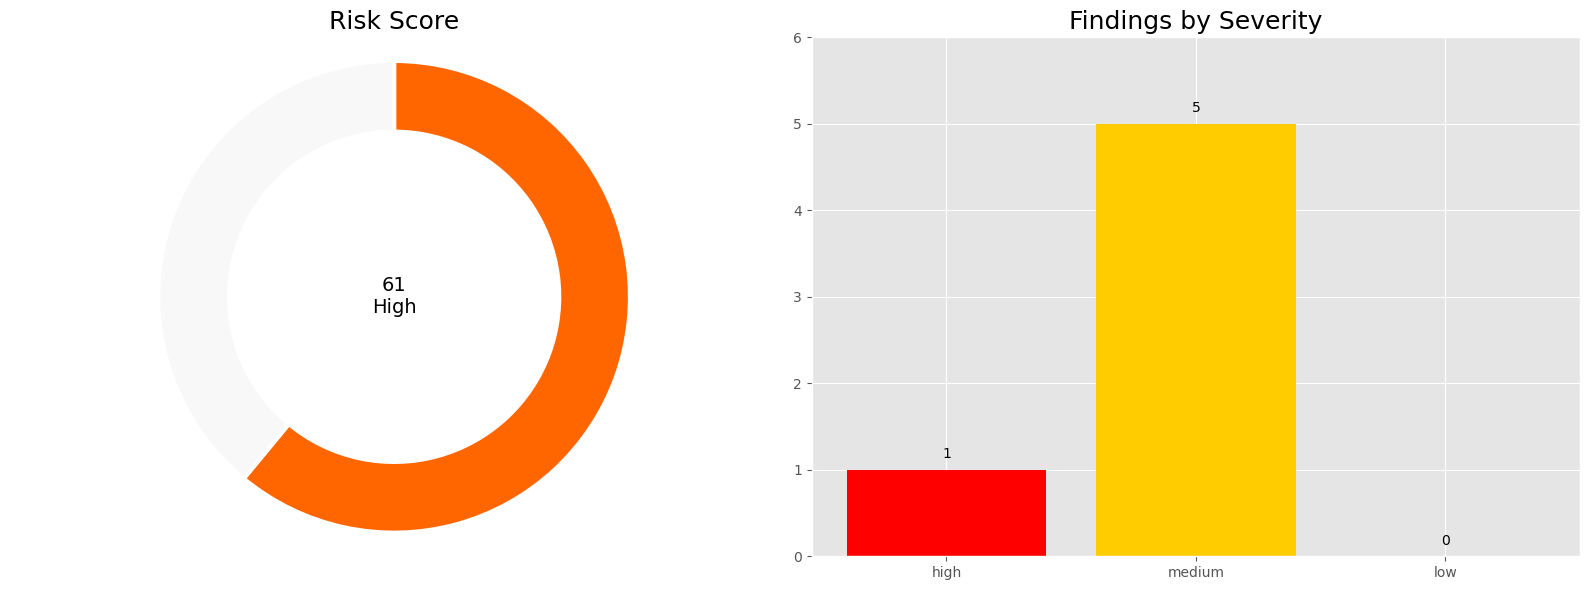

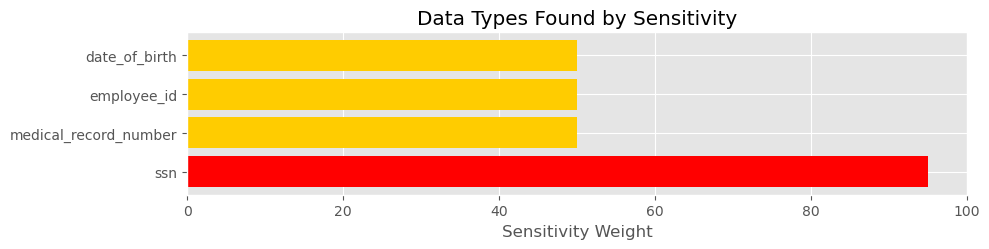

In [44]:
visualize_risk_assessment(result['risk_assessment'],
                          dlp_pipeline.risk_scorer.type_weights, dlp_pipeline.risk_scorer.default_weight)

## 4. Evaluation 

Now we will evaluate the accuracy and performance of different approaches: Regex-only, GLiNER-only, and  Hybrid approach. 

### 4.1  Evaluation of models' accuracy

In [45]:
dlp_pipeline = DLPPipeline(
    regex_patterns=patterns,
    confidence_threshold=0.3,
    model_name="gretelai/gretel-gliner-bi-small-v1.0",
    context_window=300
)

Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 24074.45it/s]


To measure the  performance of GLiNER , Hybrid and Regex models, we will usethe validation set from  `Gretel`  dataset. 

In [46]:
eval_data = run_benchmark_pipeline(gretel_dataset, dlp_pipeline, dlp_pipeline.regex_processor, dlp_pipeline.gliner_processor)

  0%|          | 3/2000 [00:00<01:24, 23.71it/s]

100%|██████████| 2000/2000 [01:52<00:00, 17.80it/s]


We evaluate the predicted results against the ground truth using the [nervalue](https://github.com/MantisAI/nervaluate) library, which computes standard Named Entity Recognition (NER) metrics including precision, recall, and F1 score. The library supports five evaluation schemes that capture different levels of alignment between predicted and reference entities, ranging from relaxed to strict matching criteria:

- **Strict** : Exact boundary surface string match and entity type
- **Exact** : Exact boundary match over the surface string, regardless of the type
- **Partial** : Partial boundary match over the surface string, regardless of the type
- **Type** : Some overlap between the system tagged entity and the gold annotation is required



In [52]:
dataset = "gretel"
all_results = pd.DataFrame()
benchmark_results = {}
for model in ['regex_results', 'hybrid_results', 'gliner_results']:
    print(f"Evaluating {model} for {dataset} dataset")
    results,  results_per_tag, result_indices, result_indices_by_tag = evaluate_results(gretel_dataset, eval_data[model], model=model, dataset=dataset)
    benchmark_results[model] = {
        'results': results,
        'results_per_tag': results_per_tag,
        'result_indices': result_indices,
        'result_indices_by_tag': result_indices_by_tag
    }


    print(results)
    print(f"-------------------------------- {model} --------------------------------")
    all_results = pd.concat([all_results, results])

Evaluating regex_results for gretel dataset
               ent_type   partial    strict     exact    missed  spurious
regex_results  0.150586  0.482679  0.126807  0.352878  0.031187  1.194764
-------------------------------- regex_results --------------------------------
Evaluating hybrid_results for gretel dataset
                ent_type   partial    strict     exact    missed  spurious
hybrid_results   0.93756  0.959141  0.923622  0.942843  0.005729   0.04434
-------------------------------- hybrid_results --------------------------------
Evaluating gliner_results for gretel dataset
                ent_type  partial    strict   exact    missed  spurious
gliner_results  0.958033  0.98076  0.954313  0.9721  0.006305  0.014945
-------------------------------- gliner_results --------------------------------


#### Overall performance metrics

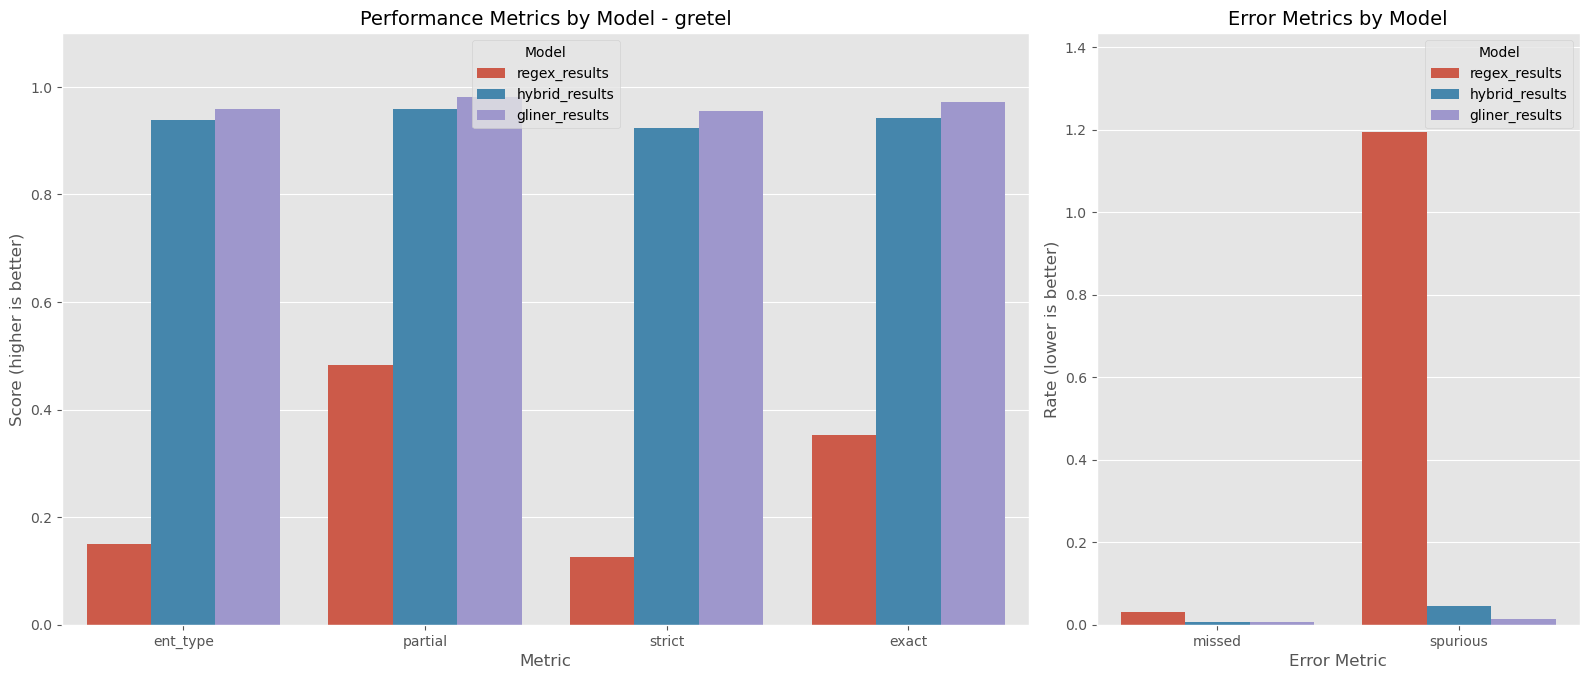

In [54]:
fig = visualize_benchmark_results(
    all_results,
    output_path=None,
    dataset_name=dataset
)

The evaluation compares the performance of three DLP configurations: `regex_only`, `hybrid`, and `GLiNER_only`. Overall, the results show that `regex_only` performs poorly across all metrics particularly on strict and exact span matching highlighting its limitations in capturing precise boundaries and semantic context. Both GLiNER_only and hybrid models shows significantly better performance, with `GLiNER_only` achieving slightly higher scores. However, the hybrid model still performs substantially better than regex_only, underscoring the benefit of context-aware verification.

In the error analysis, metrics such as **missed** (false negatives) and **spurious** (false positives) further illustrate model behavior. The regex_only model exhibits a high spurious error rate, frequently identifying irrelevant spans. In contrast, both GLiNER_only and hybrid models maintain low error rates across both categories, indicating superior precision and recall.

In summary, the hybrid model provides an effective balance combining the speed and high recall of regex with the contextual understanding of a small language model making it well suited for scalable, realtime DLP applications.

#### Performance per entity tag

We can measure the performance of individual entities and their corresponding metrics. This allows us to identify which entities are more challenging to detect than others.

<Figure size 600x800 with 0 Axes>

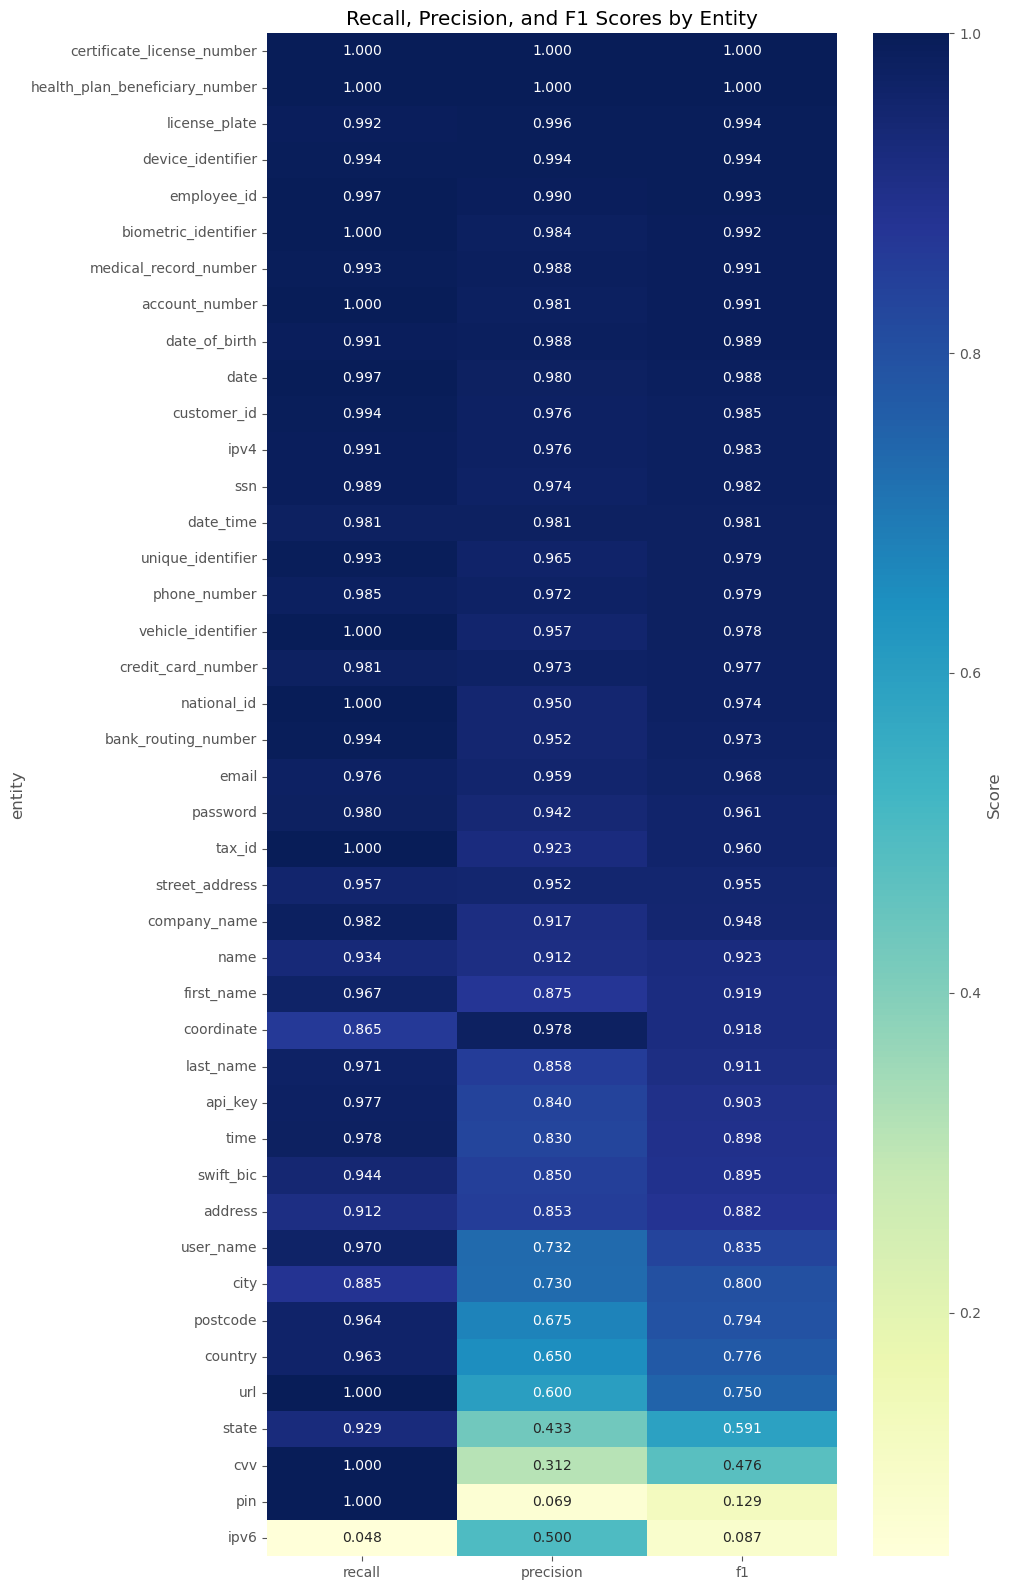

In [55]:
all_results_df,  results_per_tag, result_indices, result_indices_by_tag = list(benchmark_results['hybrid_results'].values())
metrics_df = make_metrics_per_entity(results_per_tag, metric="partial")
plot_detail_metrics(metrics_df)

This heatmap visualizes the recall, precision, and F1 scores for various PII detected using hybrid DLP pipeline. The heatmap shows that most structured identifiers (e.g., license numbers, IDs) are detected with high accuracy. Mid-tier entities like `emails` and `credit card numbers` perform reasonably well, 
while short or ambiguous entities such as `cvv`, `pin`, and `ipv6` generate large false alarm to accurately detect them, indicating they are the most challenging to detect accurately.


### 4.2 Benchmark Latency and Throughput 

To evaluate latency and throughput, we design a benchmark scenario using sample data from the Gretel dataset. To better reflect real-world DLP workloads, we augment the dataset with noisy, non-PII text, resulting in a distribution where approximately 90% of the content is non-PII and only 10% contains actual PII entities. We compare the performance across three configurations: `regex_only`, `hybrid`, and `GLiNER_only`.

Due to the high runtime cost of processing large datasets with pure language models, we illustrate the benchmark using a smaller 70MB dataset. For large-scale and more optimized evaluation, we refer readers to the optimized [DLP pipeline implementation](https://github.com/nv-morpheus/Morpheus/tree/branch-25.06/examples/data_loss_prevention), which accelerates regex matching through a C++ cudf backend. In this setup, the hybrid model is expected to process all input text but only forward a small filtered subset to the GLiNER model, whereas the `GLiNER_only` configuration processes the full dataset, resulting in higher inference time.


<!-- In the next section, we evaluate the model’s latency. We augment the `gretel` example dataset with synthetic noise to increase its size and assess whether the hybrid model can leverage the fast `RegexProcessor` filtering mechanism to improve processing speed. -->

In [56]:
# Take few examples for demonstration
latency_dataset = gretel_dataset.iloc[:200]
latency_dataset.head()

,source_text,privacy_mask,source
0,"Mclaughlin-Peters, hereafter referred to as th...","[{'label': 'first_name', 'start': 100, 'end': ...",gretel
1,"{\n ""activationCode"": ""123456"",\n ""deviceId""...","[{'label': 'user_name', 'start': 89, 'end': 98...",gretel
2,"Imaging Order for Sean Byrd-Evans, DOB: 2003-0...","[{'label': 'first_name', 'start': 18, 'end': 2...",gretel
3,**Transport Order**\n\nOrder ID: 01405479508\n...,"[{'label': 'phone_number', 'start': 31, 'end':...",gretel
4,"Cargo Manifest for Flight ABC123, Departing Ch...","[{'label': 'phone_number', 'start': 188, 'end'...",gretel


In [57]:
import numpy as np, sys 

def create_noise_text(latency_dataset, non_pii_prop=90):
    noise_text = """simply dummy text of the printing and typesetting industry. When an unknown printer took a galley of type and scrambled it to make a type specimen book.
It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. \n
It was popularised in the earlier with the release of sheets containing \n"""

    # Size estimate of nois text
    mb_param = 10000 # multiplicative factor to enlarge the toy dataset
    non_pii = non_pii_prop * latency_dataset.shape[0] # % of non-pii rows.
    mb_parameters = [mb_param*i for i in range(0,6)]
    latency_dataset['source_text'] = [ txt + noise_text* mb_parameters[i%len(mb_parameters)] for i, txt in enumerate(latency_dataset['source_text'])]
    
    # Add random repeated rows
    df = pd.DataFrame(columns=latency_dataset.columns)
    df['source_text'] = np.repeat([noise_text], non_pii)
    df['privacy_mask'] = "non-pii"
    df['source'] = "noise"
    df = pd.concat([latency_dataset, df], ignore_index=True) 
    
    return df

size_in_mb = lambda text: sys.getsizeof(text) / 1024 / 1024


non_pii_prop = 90
toy_df = create_noise_text(latency_dataset.iloc[:10, :], non_pii_prop) # use 10 pii with 900 non-pii examples
print(f"Total size {size_in_mb(toy_df)} MB. with ")

Total size 70.33520126342773 MB. with 


/tmp/ipykernel_1963188/1015466855.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latency_dataset['source_text'] = [ txt + noise_text* mb_parameters[i%len(mb_parameters)] for i, txt in enumerate(latency_dataset['source_text'])]


Running these large files takes long, let's run few examples to demonstrate the latency evaluation exercise.

In [58]:
latency_eval_data = run_benchmark_pipeline(toy_df, dlp_pipeline, dlp_pipeline.regex_processor, dlp_pipeline.gliner_processor)

  0%|          | 0/910 [00:00<?, ?it/s]/home/tad/miniforge3/envs/rapids-25.04/lib/python3.12/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 610045 has been truncated to 1024
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
  0%|          | 2/910 [00:01<09:14,  1.64it/s]/home/tad/miniforge3/envs/rapids-25.04/lib/python3.12/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 1220014 has been truncated to 1024
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
  0%|          | 3/910 [00:03<18:28,  1.22s/it]/home/tad/miniforge3/envs/rapids-25.04/lib/python3.12/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 1830049 has been truncated to 1024
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
  0%|          | 4/910 [00:06<29:43,  1.97s/it]/home/tad/miniforge3/envs/rapids-25.04

In [60]:

# Latency and throughput metrics
latency = []
for key, value in latency_eval_data['timing_metrics'].items():
    latency.append({'model': key, 'total_time': value['total_time'], 'Average per row': value['avg_latency'], 'throughput': value['throughput']})
df_latency = pd.DataFrame(latency)
df_latency.head()

,model,total_time,Average per row,throughput
0,regex,5.813783,0.006389,12.080279
1,hybrid,6.276934,0.006898,11.188922
2,gliner,33.306199,0.036600,2.108680


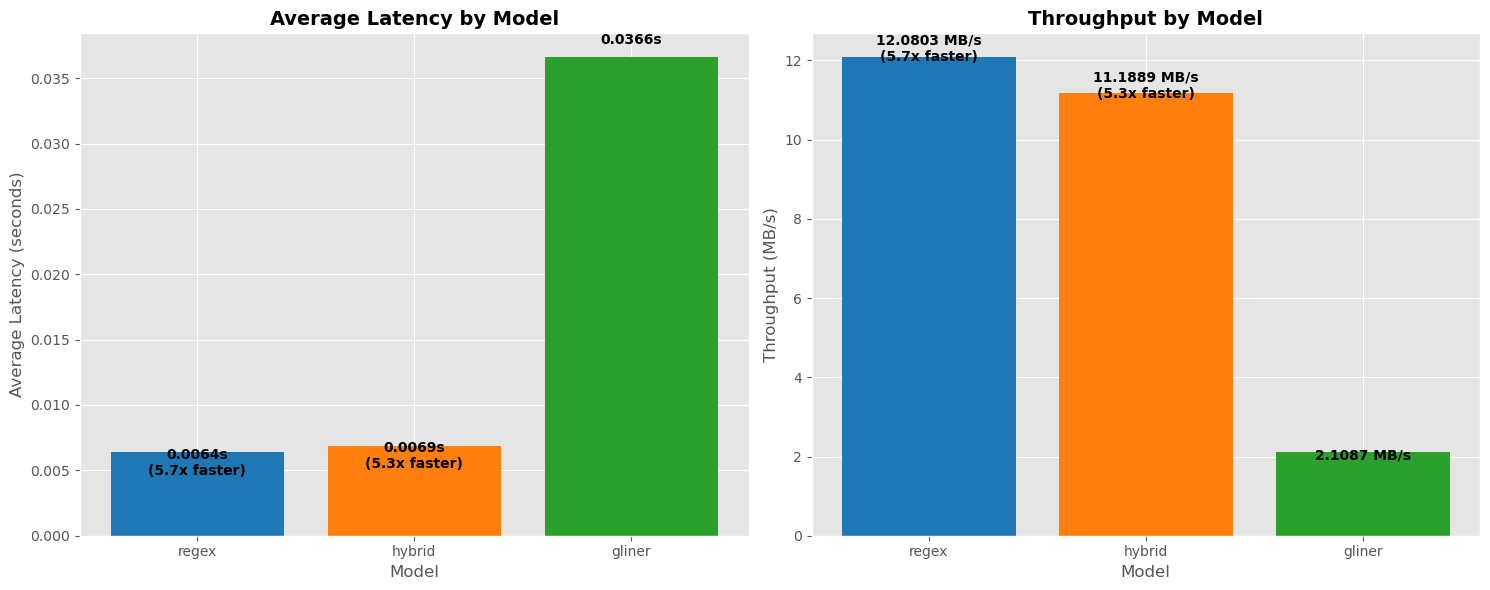

In [64]:
visualize_latency(df_latency)

The **Average Latency by Model** chart shows the average time taken by each model to process a fixed workload. The `regex_only` model is the fastest, with an average latency of 0.0.0064 seconds, followed closely by the `hybrid` model at 0.0069 seconds. In contrast, the `GLiNER-only` model is significantly slower, requiring 0.0366 seconds, making it roughly 5x slower than regex and hybrid. This indicates that the cost of GLiNER’s high accuracy (as seen in the previous chart) is increased computational time. 

The **Throughput by Model** chart shows both the regex and hybrid models achieve high throughput at approximately above 11.06 MB/s, while the GLiNER_only model processes data significantly slower at 2.91 MB/s. This performance gap is primarily due to the GLiNER model’s longer processing time when applied to the entire dataset, unlike the hybrid approach which filters input through a fast regex stage before passing only relevant segments to the language model. 

In summary, this experiment highlights a trade-off,  while the `GLiNER-only` model provides superior accuracy and minimal error rates, it suffers from significantly lower efficiency. On the other hand, the hybrid model strikes a balance, maintaining near-GLiNER accuracy while preserving high speed and throughput close to regex, making the hybrid architecture particularly attractive for real-time or large-scale DLP systems where both precision and efficiency are essential. Regex remains the fastest but is only suitable where rough pattern based detection appropriate.

# 5. Summary

This workflow shows the effectiveness of a hybrid DLP architecture, which combines the speed and efficiency of regex pattern matching with the semantic understanding capabilities of AI models. The results show the combined approach delivers better performance compared to either method used in isolation,providing both high accuracy and the scalability required for enterprise deployments. 

# 6. Reference

1. https://huggingface.co/datasets/gretelai/gretel-pii-masking-en-v1
2. https://huggingface.co/gretelai/gretel-gliner-bi-small-v1.0
3. https://aclanthology.org/2024.naacl-long.300/ 